<a href="https://colab.research.google.com/github/gustavooliveirast123-oss/Time_series/blob/main/EUA_Price_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Utilizando Algoritmos de Deep Learning para a Previsão da Taxa de Inflação

Using Deep Learnig Algorithms for Prediction of the Inflation Rate

Esse código é o que foi utilizado no meu projeto de séries temporais, na qual eu escrevi um artigo sobre. No artigo está esclarecido quais são os melhores parâmetros e variáveis de entrada para realizar as previsões. Já no código abaixo é só uma noção de como é feito e não tem como objetivo gerar os melhores resultados. https://revistagt.fpl.emnuvens.com.br/get/article/view/3182/1793 https://revistagt.fpl.emnuvens.com.br/get/article/view/3182 This code is what was used in my time series project, which I wrote an article about. The article clarifies what the best parameters and input variables are for making predictions. The code below is just an idea of ​​how it's done and is not intended to generate the best results. https://revistagt.fpl.emnuvens.com.br/get/article/view/3182/1793 https://revistagt.fpl.emnuvens.com.br/get/article/view/3182

1 - Comecei importando os dados e criando uma função de sampling para poder usar métodos de interpolação para poder aumentar ou diminuir a quantidade de dados.

2 - Criei funções gráficas para poder plotar as correlações e os dados de séries temporais, utilizando ferramentas como plotly e matplotlib.

3 - Fiz a normalização dos dados, e usei uma janela para transformar os atributos de séries temporais em variáveis semelhantes as de regressões para poder alimentar os nossos modelos de machine learning.

4 - Criei uma função para fazer previsões além do banco de dados, e fiz uma função de validação cruzada para poder dividir os nossos dados e treinar o modelo em cada bloco separadamente.

1 - I started by importing the data and creating a sampling function so I could use interpolation methods to increase or decrease the amount of data.

2 - I created graphing functions to plot correlations and time series data, using tools like plotly and matplotlib.

3 - I normalized the data and used a window to transform the time series attributes into regression-like variables to feed our machine learning models.

4 - I created a function to make predictions beyond the database, and I made a cross-validation function to split our data and train the model on each block separately.

In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import os
import plotly.io as pio
from itertools import cycle
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import warnings
from keras.models import Sequential
from keras.layers import Dense
import keras
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Lambda, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import rc
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

In [139]:
cvd_df = pd.read_excel('/content/bancodedados.xlsx')

In [140]:
cvd_df['DATE'] = pd.to_datetime(cvd_df['DATE'])

In [141]:
cvd_df.set_index('DATE', inplace=True)

In [142]:
def sampling(dataset, period):
    upsampled = dataset.resample(period)
    df = upsampled.interpolate(method='linear')

    return df

In [143]:
cvd_df = sampling(cvd_df, 'D')

In [144]:
cvd_df = cvd_df[['PRICE', 'GDPC', 'DFF']]

In [145]:
cvd_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19724 entries, 1970-01-01 to 2024-01-01
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRICE   19724 non-null  float64
 1   GDPC    19724 non-null  float64
 2   DFF     19724 non-null  float64
dtypes: float64(3)
memory usage: 616.4 KB


In [146]:
cvd_df.cov()

PRICE          GDPC           DFF
PRICE     7.446307 -8.645045e+03      8.028537
GDPC  -8645.044560  2.647143e+07 -14548.847442
DFF       8.028537 -1.454885e+04     15.234924

In [147]:
cvd_df.corr()

PRICE      GDPC       DFF
PRICE  1.000000 -0.615755  0.753782
GDPC  -0.615755  1.000000 -0.724469
DFF    0.753782 -0.724469  1.000000

Gráfico

In [148]:
def graph_corr(banco, coluna1, coluna2, size):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=banco.index, y=banco[coluna1], name=f"{coluna1}", yaxis="y1"))
  fig.add_trace(go.Scatter(x=banco.index, y=banco[coluna2], name=f"{coluna2}", yaxis="y2"))
  fig.update_layout(
  xaxis=dict(title="Data", titlefont = {'size': size} , showgrid=True, gridcolor='black'),
  yaxis1=dict(title="Valor1", titlefont = {'size': size}),
  yaxis2=dict(title="Valor2", anchor="free", overlaying="y", autoshift=True, titlefont = {'size': size} , showgrid=True, gridcolor='black', zeroline=True,
        zerolinecolor='black',
        zerolinewidth=1,
              side='right'),
  title_text= f"Correlação entre {coluna1} e {coluna2} ",
  width=900,
  paper_bgcolor='white',
  plot_bgcolor='white',
  title={
        'text':  f"Correlação entre {coluna1} e {coluna2}",
        'x': 0.5,
        'y': 0.9,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
           'size': 15,
           'color': 'Black',
           'family': 'Arial'
         }
      }
)
  return fig.show()




In [149]:
def graph(banco, coluna1,  size):
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=banco.index, y=banco[coluna1], name=f"{coluna1}", yaxis="y1"))
  fig.update_layout(
  xaxis=dict(title="Data", titlefont = {'size': size} , showgrid=True, gridcolor='black'),
  yaxis1=dict(title="Valor", anchor="free", overlaying="y", autoshift=True, titlefont = {'size': size} , showgrid=True, gridcolor='black', zeroline=True,
        zerolinecolor='black',
        zerolinewidth=1),
  width=900,
  paper_bgcolor='white',
  plot_bgcolor='white',
  title={
        'text':  f"{coluna1}",
        'x': 0.5,
        'y': 0.9,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
           'size': 15,
           'color': 'Black',
           'family': 'Arial'
         }
      }
)
  return fig.show()



In [150]:
def graph2(data, coluna1, coluna2):
  plt.plot(data[coluna1], color = 'red', label = 'Real Price')
  plt.plot(data[coluna2], color = 'blue', label = 'Predicted  Price')
  plt.title('Price Prediction')
  plt.xlabel('Time')
  plt.ylabel(' Price')
  plt.legend()
  plt.show()

In [151]:
graph(cvd_df, 'PRICE', 15)

In [152]:
graph_corr(cvd_df, 'PRICE', 'GDPC', 15)

In [153]:
graph_corr(cvd_df, 'PRICE', 'DFF', 15)

Divisão

In [154]:
def division(dataset, value):
  v = dataset.shape[0] / value
  vv = int(v)
  lista = []
  for i in range(1,value+1,1):
    if i < value:
      a = i - 1
      div = dataset[vv * a : vv * i]
      lista.append(div)
    elif i == value:
      a = i - 1
      div = dataset[vv * a :]
      lista.append(div)
  return lista

In [155]:
df = division(cvd_df,3)

In [156]:
df[0]

PRICE         GDPC       DFF
DATE                                       
1970-01-01  6.592370  5300.652000  8.980000
1970-01-02  6.607255  5300.732774  8.980000
1970-01-03  6.622140  5300.813548  8.980000
1970-01-04  6.637025  5300.894323  8.980000
1970-01-05  6.651910  5300.975097  8.980000
...              ...          ...       ...
1987-12-27  4.360091  9364.912215  6.820323
1987-12-28  4.362720  9365.430172  6.822258
1987-12-29  4.365348  9365.948129  6.824194
1987-12-30  4.367977  9366.466086  6.826129
1987-12-31  4.370605  9366.984043  6.828065

[6574 rows x 3 columns]

In [157]:
def train_test(dataset, porc):
  train_size = int(len(dataset) * porc)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
  return train, test

In [158]:
train,test = train_test(df[0], 0.80)

In [159]:
def normalize(train, test):
  min = MinMaxScaler()
  train_min = min.fit_transform(train)
  test_min = min.transform(test)
  return train_min, test_min, min

In [160]:
train_minn, test_minn, min = normalize(train, test)

In [161]:
train_minn.shape, test_minn.shape

((5259, 3), (1315, 3))

In [162]:
def window_2d(data, passos, prevdays):
  xtreino = []
  for i in range(0, data.shape[0]- (passos + prevdays), 1):
    ed = []
    tr = data[0+i:passos+i]
    rd = [(ed.append(tr[a])) for a in range(0,passos,1)]
    fg = np.concatenate((ed))
    xtreino.append(fg)
    ed.clear()

  xtreinon = np.array((xtreino))
  ytreino = []
  trr = data[:,0]
  for i in range(passos, data.shape[0] - prevdays, 1):
    ed = []
    tr = trr[i+1:i+prevdays+1]
    rd = [(ed.append(tr[a])) for a in range(0,prevdays,1)]
    fg = np.array(ed)
    ytreino.append(fg)
    ed.clear

  ytreinon = np.array((ytreino))
  return xtreinon, ytreinon

In [163]:
train_minx, train_miny = window_2d(train_minn, 4, 1)
test_minx, test_miny = window_2d(test_minn, 4, 1)

In [164]:
train_minx.shape, train_miny.shape, test_minx.shape, test_miny.shape

((5254, 12), (5254, 1), (1310, 12), (1310, 1))

In [165]:
def window_3d_convert(trainx,trainy,testx,testy,passos, daysfuture):
  trainxfuture = trainx.shape[1] / passos
  trainyfuture = trainy.shape[1] / daysfuture
  testxfuture = testx.shape[1] / passos
  testyfuture = testy.shape[1] / daysfuture
  train_minxx = trainx.reshape(trainx.shape[0],passos,int(trainxfuture))
  train_minxy = trainy.reshape(trainy.shape[0],daysfuture,int(trainyfuture))
  test_minxx = testx.reshape(testx.shape[0],passos,int(testxfuture))
  test_minxy = testy.reshape(testy.shape[0],daysfuture,int(testyfuture))
  return train_minxx, train_minxy, test_minxx, test_minxy

In [166]:
train_minxx, train_minxy, test_minxx, test_minxy = window_3d_convert(train_minx, train_miny, test_minx, test_miny, 4,1)

In [167]:
def window_3d(data, passos, prevdays):
  xtreino = []
  for i in range(0, data.shape[0]- (passos + prevdays), 1):
    tr = data[0+i:passos+i]
    xtreino.append(tr)

  xtreinon = np.array((xtreino))
  ytreino = []
  trr = data[:,0]
  for i in range(passos, data.shape[0] - prevdays, 1):
    tr = trr[i+1:i+prevdays+1]
    ytreino.append(tr)

  ytreinon = np.array(ytreino)
  return xtreinon, ytreinon

In [168]:
train_minx, train_miny = window_3d(train_minn, 4, 1)
test_minx, test_miny = window_3d(test_minn, 4, 1)

In [169]:
def model(train_minx, train_miny, test_minx, test_miny):
  model = Sequential()
  model.add(LSTM(8, activation='relu', input_shape=(train_minx.shape[1],train_minx.shape[2]), return_sequences=True))
  #model.add(tf.keras.layers.Dropout(0.2))
  #model.add(LSTM(8, activation='relu', return_sequences=True))
  model.add(LSTM(4, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae', metrics=["mae"])
  callbacks = keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose=1, restore_best_weights=True)
  history = model.fit(train_minx,train_miny,  epochs=10, callbacks=[],  batch_size=8, validation_data=(test_minx, test_miny))
  evaltest = model.evaluate(test_minx, test_miny)
  evaltrain = model.evaluate(train_minx, train_miny)
  pred = model.predict(test_minx)
  rr = history.history['loss']
  pl1 = plt.plot(rr)
  ff = history.history['val_mae']
  pl2 = plt.plot(ff)

  return model, evaltest, evaltrain

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0722 - mae: 0.0722 - val_loss: 0.0045 - val_mae: 0.0045
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0098 - mae: 0.0098 - val_loss: 0.0115 - val_mae: 0.0115
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0096 - mae: 0.0096 - val_loss: 0.0111 - val_mae: 0.0111
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0082 - mae: 0.0082 - val_loss: 0.0128 - val_mae: 0.0128
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0079 - mae: 0.0079 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0079 - mae: 0.0079 - val_loss: 0.0100 - val_mae: 0.0100
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0071 - mae: 0.0071 - val_loss: 0.0023 - val_mae: 0.0023
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0091 - mae: 0.0091 - val_loss: 0.0052 - val_mae: 0.0052
Epoch 9/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0083 

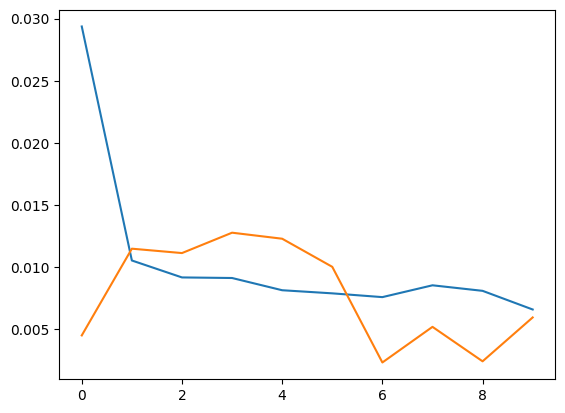

In [170]:
modelo, evaltestt, evaltrainn= model(train_minx, train_miny, test_minx, test_miny)

In [171]:
def beyond_prevision(train, test, alvo, min, passos, daysfuture, model):
  dfpast = train.iloc[-91: -1]
  dffuture = test.copy()
  dffuture.reset_index(inplace=True)
  data1 = dffuture['DATE']
  dffuture.set_index('DATE', inplace=True)
  dffuture[alvo] = np.nan
  dfpastmin = min.transform(dfpast)
  dffuturemin = min.transform(dffuture)
  full_df = pd.concat([pd.DataFrame(dfpastmin), pd.DataFrame(dffuturemin)], axis=0)
  full_dff = full_df.copy()
  full_dfff = full_df.copy()
  passos = passos
  daysfuture = daysfuture
  size = test.shape[0]
  prev = []
  for i,x in enumerate(range(passos, size + passos, daysfuture)):
       ef = []
       f = i + 1
       rr = full_dff.iloc[0:passos]
       rg = np.array(rr)
       rgg = rg.reshape(1,passos, 3)
       pre = model.predict(rgg)
       full_dff = full_dff.iloc[daysfuture:]
       full_dff.iloc[passos - daysfuture:passos,0] = pre
       prev.append(pre)

  new_array=np.array(prev)
  new_array=new_array.reshape(-1,1)
  prediction_copies_array = np.repeat(new_array,3, axis=-1)
  y_pred_future = min.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),3)))[:,0]
  gj = pd.DataFrame(y_pred_future)
  gj1 = test.copy()
  gj1.reset_index(inplace=True)
  gj2 = gj1['PRICE']
  mv = pd.concat([data1, gj, gj2], axis=1)
  mv.rename(columns={0: 'Previsão'}, inplace=True)
  mv.set_index('DATE', inplace=True)
  mw = mv
  gr = graph2(mw, 'Previsão', 'PRICE')
  return gr, mw

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

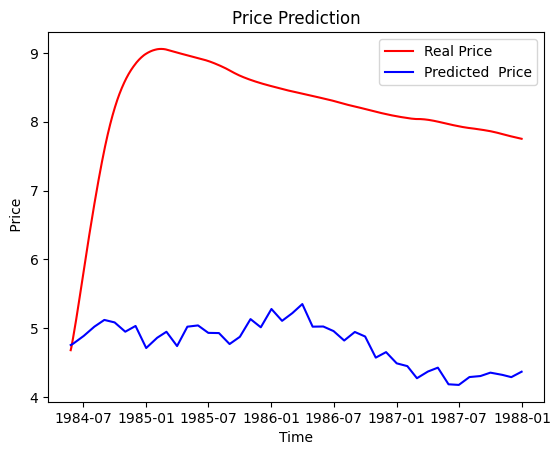

In [172]:
aaa, bbb = beyond_prevision(train, test, 'PRICE',min, 4, 1,modelo)

Cross_val_score

In [173]:
def cross_val_score(dataset, value):
   v = dataset.shape[0] / value
   vv = int(v)
   lista = []

   for i in range(1,value+1,1):
     if i < value:
       a = i - 1
       div = dataset[vv * a : vv * i]
     elif i == value:
       a = i - 1
       div = dataset[vv * a :]

     train,test = train_test(div, 0.80)
     train_minn, test_minn, min = normalize(train, test)
     train_minx, train_miny = window_3d(train_minn, 4, 1)
     test_minx, test_miny = window_3d(test_minn, 4, 1)
     modelo, evaltestt, evaltrainn= model(train_minx, train_miny, test_minx, test_miny)
     aaa, bbb = beyond_prevision(train, test, 'PRICE',min, 4, 1, modelo)
     lista.append(bbb)

   return lista

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0611 - mae: 0.0611 - val_loss: 0.0042 - val_mae: 0.0042
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0112 - mae: 0.0112 - val_loss: 0.0267 - val_mae: 0.0267
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0101 - mae: 0.0101 - val_loss: 0.0093 - val_mae: 0.0093
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0091 - mae: 0.0091 - val_loss: 0.0046 - val_mae: 0.0046
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0100 - mae: 0.0100 - val_loss: 0.0056 - val_mae: 0.0056
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0076 - mae: 0.0076 - val_loss: 0.0122 - val_mae: 0.0122
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0077 - mae: 0.0077 - val_loss: 0.0058 - val_mae: 0.0058
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0077 - mae: 0.0077 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 9/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0076

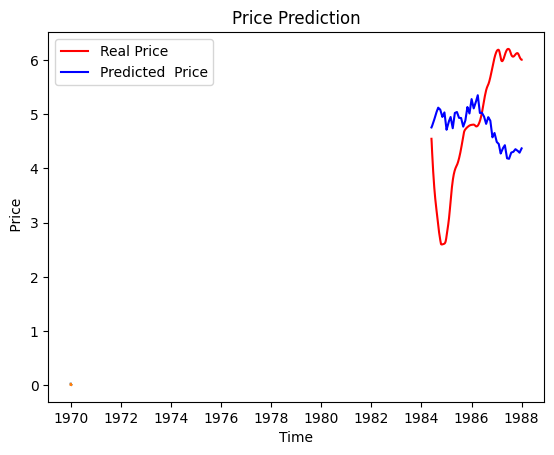

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0462 - mae: 0.0462 - val_loss: 0.0131 - val_mae: 0.0131
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0095 - mae: 0.0095 - val_loss: 0.0187 - val_mae: 0.0187
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0090 - mae: 0.0090 - val_loss: 0.0145 - val_mae: 0.0145
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0089 - mae: 0.0089 - val_loss: 0.0094 - val_mae: 0.0094
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0101 - val_mae: 0.0101
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0074 - mae: 0.0074 - val_loss: 0.0095 - val_mae: 0.0095
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0086 - mae: 0.0086 - val_loss: 0.0129 - val_mae: 0.0129
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0071 - mae: 0.0071 - val_loss: 0.0122 - val_mae: 0.0122
Epoch 9/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0085 

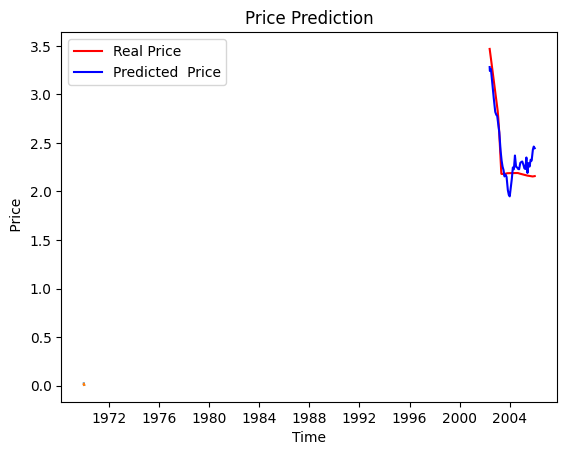

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.1026 - mae: 0.1026 - val_loss: 0.2039 - val_mae: 0.2039
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0133 - mae: 0.0133 - val_loss: 0.0820 - val_mae: 0.0820
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0095 - mae: 0.0095 - val_loss: 0.0804 - val_mae: 0.0804
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0108 - mae: 0.0108 - val_loss: 0.0643 - val_mae: 0.0643
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0082 - mae: 0.0082 - val_loss: 0.0532 - val_mae: 0.0532
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0077 - mae: 0.0077 - val_loss: 0.0580 - val_mae: 0.0580
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0097 - mae: 0.0097 - val_loss: 0.0775 - val_mae: 0.0775
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0080 - mae: 0.0080 - val_loss: 0.0636 - val_mae: 0.0636
Epoch 9/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0088

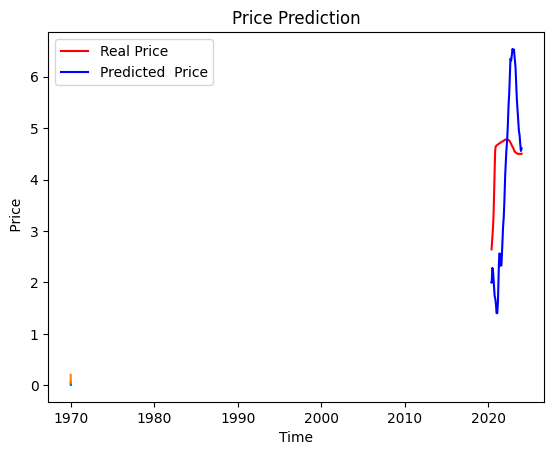

In [174]:
bb = cross_val_score(cvd_df, 3)

In [187]:
bb[0].corr()

Previsão     PRICE
Previsão  1.000000 -0.668171
PRICE    -0.668171  1.000000

In [188]:
a1 = bb[0]

In [189]:
mean_absolute_error(a1['Previsão'], a1['PRICE'])

1.209409022288336

In [190]:
bb[1].corr()

Previsão     PRICE
Previsão  1.000000  0.941806
PRICE     0.941806  1.000000

In [191]:
a2 = bb[1]

In [192]:
mean_absolute_error(a2['PRICE'], a2['Previsão'])

0.11802915449339453

In [193]:
bb[2].corr()

Previsão     PRICE
Previsão  1.000000  0.304875
PRICE     0.304875  1.000000

In [194]:
a3 = bb[2]

In [195]:
mean_absolute_error(a3['PRICE'], a3['Previsão'])

1.4698871989170588

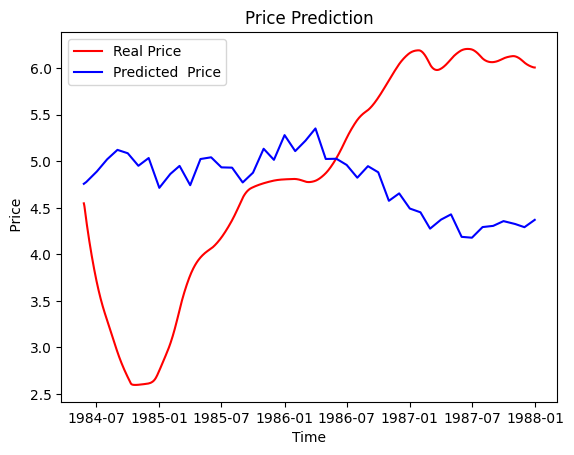

In [196]:
graph2(bb[0], 'Previsão', 'PRICE')

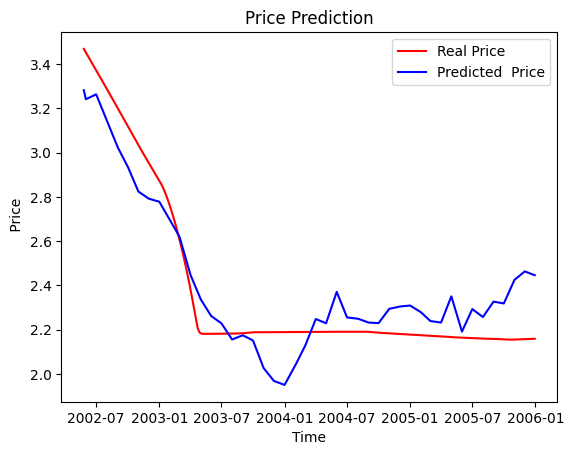

In [197]:
graph2(bb[1], 'Previsão', 'PRICE')

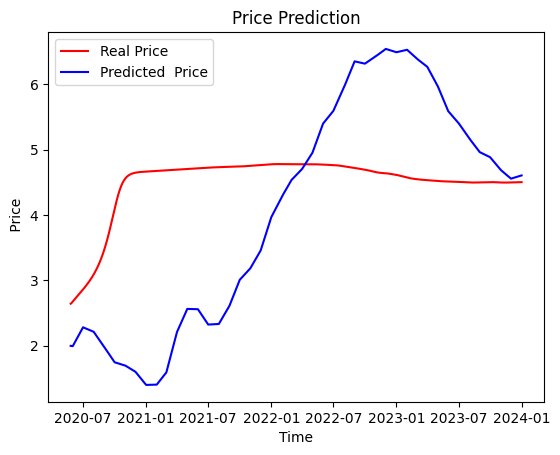

In [198]:
graph2(bb[2], 'Previsão', 'PRICE')